### #3. Logistic Regression with BGD

In [2]:
import numpy as np
import matplotlib.pyplot as plt

**1) 데이터 불러오기**

In [3]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

**2) 모델 클래스 생성**

In [11]:
class SingleLayerBGD:
    def __init__(self, learning_rate=0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1 = l1
        self.l2 = l2
        
    def forpass(self, x):
        z = np.dot(x, self.w) + self.b
        return z
    
    def backprop(self, x, err):
        m = len(x)
        w_grad = np.dot(x.T, err) / m
        b_grad = np.sum(err) / m
        return w_grad, b_grad
    
    def activation(self, z):
        a = 1 / (1 + np.exp(-z))
        return a
    
    def reg_loss(self):
        return self.l1 * np.sum(np.abs(self.w)) + self.l2 / 2 * np.sum(self.w ** 2)
    
    def update_val_loss(self, x_val, y_val):
        val_loss = 0
        z = self.forpass(x_val)
        a = self.activation(z)
        a = np.clip(a, 1e-10, 1 - 1e-10)
        val_loss = np.sum(-(y_val * np.log(a) + (1 - y_val) * np.log(1 - a)))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))
        
    def predict(self, x):
        z = self.forpass(x)
        return z > 0
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y.reshape(-1, 1))
    
    def fit(self, x, y, x_val=None, y_val=None, epochs=100):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        m = len(x)
        self.w = np.ones((x.shape[1], 1))
        self.b = 0
        self.w_history.append(self.w.copy())
        loss = 0
        
        for i in range(epochs):
            z = self.forpass(x)
            a = self.activation(z)
            err = -(y - a)
            w_grad, b_grad = self.backprop(x, err)
            w_grad += (self.l1 * np.sign(self.w) + self.l2 * self.w) / m
            self.w -= self.lr * w_grad
            self.b -= self.lr * b_grad
            self.w_history.append(self.w.copy())
            a = np.clip(a, 1e-10, 1 - 1e-10)
            loss += np.sum(-(y * np.log(a) + (1 - y) * np.log(1 - a)))
            self.losses.append((loss + self.reg_loss()) / m)
            self.update_val_loss(x_val, y_val)

**3) 훈련 데이터 & 검증 데이터 분할**

In [6]:
from sklearn.model_selection import train_test_split

X_train_all, X_test, y_train_all, y_test = train_test_split(
    X, y, stratify=y, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_all, y_train_all, stratify=y_train_all, random_state=42
)

**4) 데이터 전처리**

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

**5) 모델 훈련**

In [12]:
single_layer = SingleLayerBGD()
single_layer.fit(X_train_scaled, y_train, X_val_scaled, y_val)

In [13]:
print('검증 데이터 성능 정확도: {:.2f}'.format(single_layer.score(X_val_scaled, y_val)))

검증 데이터 성능 정확도: 0.97


**6) 손실 그래프**

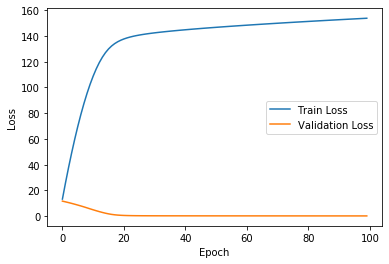

In [14]:
plt.plot(single_layer.losses)
plt.plot(single_layer.val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()